In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from textblob import TextBlob
import advertools
import re
import spacy
import xgboost
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report,auc, 
                            roc_auc_score, precision_score,
                            recall_score,f1_score, accuracy_score)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import gensim
import nltk
import nltk.util
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Dropout, SpatialDropout1D, LSTM, Conv1D, MaxPool1D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import pad_sequences
from transformers import BertTokenizer, TFBertForSequenceClassification, TFBertModel
import warnings
warnings.filterwarnings("ignore")
nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package wordnet to C:\Users\Ali
[nltk_data]     Haider\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Ali
[nltk_data]     Haider\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import tensorflow as tf
tf.__version__

'2.10.1'

In [3]:
data_path = Path.cwd().parent/"Data"
final_data = pd.DataFrame()

In [4]:
for child in data_path.iterdir():
    for child_ch in child.iterdir():
        if child_ch.is_dir():
            files = list(child_ch.glob("**/*.csv"))
            for fls in tqdm(range(len(files))):
                df = pd.read_csv(files[fls])
        else:
            df = pd.read_csv(child_ch)
        final_data = pd.concat([df,final_data],axis = 0)

100%|██████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 55.18it/s]


In [5]:
final_data = final_data[final_data["class"]!="CONTROL"]

In [6]:
pipeline_data = final_data.copy()

# Data Preprocessing

In [8]:
def clean_text(text:str) -> str:
    tokens = advertools.word_tokenize(text,phrase_len=1)
    emoji_token = advertools.extract_emoji(tokens[0])
    emoji_token = emoji_token["emoji_text"]
    for tok in range(0,len(emoji_token)):
        if emoji_token[tok]:
            tokens[0][tok] = " ".join(emoji_token[tok])
    clean_text = " ".join(tokens[0])
    clean_pattern = r"@\w+|#\w+|\W+|x+|https\.\//www\.(\w+|\W+)\.com|http\w*|www\.(\w+|\W+)\.com|user\w*|\d+"
    clean_text = re.sub(clean_pattern," ",clean_text).strip()
    clean_text = re.sub(r"\s+"," ",clean_text).strip()
    return clean_text

In [9]:
def text_lemmatize(text: str) -> str:
    lemma = WordNetLemmatizer()
    tokens = advertools.word_tokenize(text,phrase_len=1)
    text = [lemma.lemmatize(tok) for tok in tokens[0]]
    return " ".join(text)

In [11]:
def remove_stopword(text: str) -> str:
    tokens = advertools.word_tokenize(text,phrase_len=1)[0]
    stop_words = stopwords.words("english")
    clean_word = [tok for tok in tokens if tok not in stop_words]
    return " ".join(clean_word)

In [12]:
def generate_n_grams(text: str, n: list[int]) -> list[tuple]:
    tokens = advertools.word_tokenize(text,phrase_len=1)[0]
    if len(n)<=1:
        n_grams = list(nltk.ngrams(tokens,n[0],pad_right=True,right_pad_symbol="</s>"))
        bag_ngrams = " ".join(["_".join(c) for c in n_grams])
    else:
        bag_ngrams = " "
        for n_gram in range(n[0],n[1]+1):
            n_grams = list(nltk.ngrams(tokens,n_gram,pad_right=True,right_pad_symbol="</s>"))
            if n_gram==1:       
                n_grams = " ".join(["".join(c[0]) for c in n_grams])
                bag_ngrams+=n_grams
            else:
                n_grams = " ".join(["_".join(c) for c in n_grams])
                bag_ngrams+=" "+n_grams
    return bag_ngrams

In [13]:
def tfidf(train: pd.DataFrame, test:pd.DataFrame()):
    tf_idf = TfidfVectorizer()
    train_feat = tf_idf.fit_transform(train)
    test_feat = tf_idf.transform(test)
    return train_feat,test_feat

In [14]:
def classification_metrics(actuals: np.array, preds: np.array, average:"binary") -> pd.DataFrame:
    metrics_performance = pd.DataFrame()
    precision = precision_score(actuals,preds,average=average)
    recall = recall_score(actuals,preds,average=average)
    f1 = f1_score(actuals,preds,average=average)
    accuracy = accuracy_score(actuals,preds)
    metrics_performance["precision"] = [precision]
    metrics_performance["recall"] = [recall]
    metrics_performance["f1"] = [f1]
    metrics_performance["accuracy"] = [accuracy]
    return metrics_performance

In [15]:
def data_preprocess_pipeline(data_preprocess: pd.DataFrame,
                             # ngram_range: list,
                            filename: str,
                            ) -> pd.DataFrame:
    data_preprocess = data_preprocess[~(data_preprocess["tweet"].isnull())]
    data_preprocess = data_preprocess[["class","tweet"]]
    data_preprocess.rename(columns={"class":"Disorder"}, inplace=True)
    data_preprocess["tweet"] = data_preprocess["tweet"].apply(clean_text)
    data_preprocess["tweet"] = data_preprocess["tweet"].apply(text_lemmatize)
    data_preprocess["tweet"] = data_preprocess["tweet"].apply(remove_stopword)
    data_preprocess = data_preprocess[data_preprocess["tweet"]!=""]
    # data_preprocess["text_features"] = data_preprocess["tweet"].apply(lambda text: 
    #                                                                   generate_n_grams(text,n=ngram_range))
    print("saving preprocessed data")
    data_preprocess.to_csv(filename,index=False)
    print("data saved")
    return data_preprocess

# Imbalaned Dataset training

In [1]:
data_preprocess = data_preprocess_pipeline(pipeline_data,
                                           filename="imbalanced_data_preprocess.csv",
                                           )
data_preprocess.head()

In [18]:
data_preprocess.Disorder.value_counts()

Disorder
ADHD               3018
SCHIZOPHRENIA      2959
OCD                2888
ANXIETY            2719
PTSD               2458
DEPRESSION         2143
AUTISM             1402
EATING DISORDER     402
BIPOLAR             243
Name: count, dtype: int64

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_preprocess["tweet"].values.tolist())

In [20]:
corpus = [advertools.word_tokenize(text,phrase_len=1)[0] for text in data_preprocess["tweet"].values]

In [94]:
WORD2VEC_DIM = 300
SG = {"CBOW":0,"SKIP_GRAM":1}
word2vec = gensim.models.Word2Vec(corpus,window=5,vector_size=WORD2VEC_DIM,min_count=1,epochs=100,sg=SG["CBOW"])
WORD2VEC_VOCAB_SIZE = len(word2vec.wv.index_to_key)+1
word2vec_embedding = np.zeros((WORD2VEC_VOCAB_SIZE,WORD2VEC_DIM))
for word,index in tokenizer.word_index.items():
    if word in word2vec.wv.index_to_key:
        word2vec_embedding[index] = word2vec.wv[word]

2024-08-19 14:09:42,753 | INFO | word2vec.py:582 | scan_vocab | collecting all words and their counts
2024-08-19 14:09:42,757 | INFO | word2vec.py:565 | _scan_vocab | PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-08-19 14:09:42,803 | INFO | word2vec.py:565 | _scan_vocab | PROGRESS: at sentence #10000, processed 114796 words, keeping 12249 word types
2024-08-19 14:09:42,839 | INFO | word2vec.py:588 | scan_vocab | collected 16114 word types from a corpus of 181302 raw words and 18232 sentences
2024-08-19 14:09:42,839 | INFO | word2vec.py:637 | prepare_vocab | Creating a fresh vocabulary
2024-08-19 14:09:42,971 | INFO | utils.py:447 | add_lifecycle_event | Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 16114 unique words (100.00% of original 16114, drops 0)', 'datetime': '2024-08-19T14:09:42.971369', 'gensim': '4.3.3', 'python': '3.10.14 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:44:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows

In [95]:
word2vec_embedding.shape

(16115, 300)

In [141]:
GLOVE_VOCAB_SIZE = len(tokenizer.word_index)+1
EMBEDDINGS_DIMENSION = 300
glove_embeddings = np.zeros((GLOVE_VOCAB_SIZE,EMBEDDINGS_DIMENSION))
glove_model = spacy.load("en_core_web_lg")
for word,index in tokenizer.word_index.items():
    if word in glove_model.vocab.strings:
        glove_embeddings[index] = glove_model.vocab[word].vector

In [142]:
glove_embeddings.shape

(16113, 300)

In [162]:
import fasttext

In [163]:
with open("corpus.txt","w", encoding="utf-8") as file:
    for doc in data_preprocess["tweet"].values:
        file.write(doc + "\n")
MODEL_TYPE = "skipgram"
EMBEDDINGS_DIMENSION = 300
FASTTEXT_VOCAB_SIZE = len(tokenizer.word_index)+1
fasttext_embeddings = np.zeros((FASTTEXT_VOCAB_SIZE,EMBEDDINGS_DIMENSION))
fasttext_model = fasttext.train_unsupervised("corpus.txt",ws=5,minn=2,epoch=100,dim=300,model=MODEL_TYPE)
for word,index in tokenizer.word_index.items():
    if word in fasttext_model.words:
        fasttext_embeddings[index] = fasttext_model.get_word_vector(word)

In [164]:
fasttext_embeddings.shape

(16113, 300)

In [184]:
import tensorflow_hub as hub

In [185]:
ELMO_VOCAB_SIZE = len(data_preprocess)
EMBEDDINGS_DIMENSION = 1024

elmo_embeddings = np.zeros((ELMO_VOCAB_SIZE,EMBEDDINGS_DIMENSION))
elmo = hub.KerasLayer("https://tfhub.dev/google/elmo/3")
for index,text in enumerate(data_preprocess["tweet"].values):
    # print("index",index)
    embeddings = elmo(tf.constant([text]))
    elmo_embeddings[index]=embeddings.numpy()

2024-08-19 17:53:11,142 | INFO | resolver.py:108 | tfhub_cache_dir | Using C:\Users\ALIHAI~1\AppData\Local\Temp\tfhub_modules to cache modules.


In [186]:
elmo_embeddings.shape

(18232, 1024)

In [206]:
BERT_VOCAB_SIZE = len(data_preprocess)
EMBEDDINGS_DIMENSION = 768

bert_embeddings = np.zeros((BERT_VOCAB_SIZE,EMBEDDINGS_DIMENSION))
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
for index,text in enumerate(data_preprocess["tweet"].values):
    # print("index",index)
    inputs = bert_tokenizer(text, padding=True,return_tensors='tf')
    outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state
    cls_embeddings = embeddings[:, 0, :]
    bert_embeddings[index]=cls_embeddings.numpy()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [207]:
bert_embeddings.shape

(18232, 768)

In [21]:
max_length_sequence = max([len(doc) for doc in corpus])
max_length_sequence

186

In [22]:
sequence = tokenizer.texts_to_sequences(data_preprocess["tweet"].values)
padded_sequence = pad_sequences(sequence,maxlen=max_length_sequence,padding="pre")

In [23]:
padded_sequence

array([[   0,    0,    0, ...,  319,  498, 1803],
       [   0,    0,    0, ...,  563,    5,  347],
       [   0,    0,    0, ...,    2,   93,    5],
       ...,
       [   0,    0,    0, ..., 8992,   97, 8992],
       [   0,    0,    0, ...,  583,  334,  565],
       [   0,    0,    0, ..., 3682, 4070, 8983]])

In [24]:
# EMBEDDINGS_DIMENSION
encode_target = dict(zip(data_preprocess["Disorder"].unique(),np.arange(0,data_preprocess["Disorder"].nunique(),dtype=int)))
data_preprocess["Disorder"] = data_preprocess["Disorder"].map(encode_target)
data_preprocess["Disorder"]=data_preprocess["Disorder"].map(int)

In [25]:
data_preprocess.Disorder.value_counts()

Disorder
8    3018
0    2959
2    2888
7    2719
1    2458
4    2143
6    1402
3     402
5     243
Name: count, dtype: int64

### LSTM

In [208]:
embedding = bert_embeddings
vocab_size = BERT_VOCAB_SIZE
embedding_dim = EMBEDDINGS_DIMENSION
learning_rate = 0.01
Embedding_layer = Embedding(vocab_size,embedding_dim,weights = [embedding],input_length = max_length_sequence, trainable=False)
model = Sequential()
model.add(Embedding_layer)
model.add(Dropout(0.2))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(9,"softmax"))
model.compile(loss="sparse_categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),metrics=["accuracy"])

2024-08-19 20:32:25,721 | WARNING | lstm.py:590 | __init__ | Layer lstm_8 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


In [209]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 186, 768)          14002176  
                                                                 
 dropout_45 (Dropout)        (None, 186, 768)          0         
                                                                 
 lstm_8 (LSTM)               (None, 100)               347600    
                                                                 
 dense_8 (Dense)             (None, 9)                 909       
                                                                 
Total params: 14,350,685
Trainable params: 348,509
Non-trainable params: 14,002,176
_________________________________________________________________


In [28]:
data_preprocess.head(2)

,Disorder,tweet
0,0,sally white heart white heart wont forget angel
1,0,personally life split two everything psychosis...


In [29]:
data_bin = data_preprocess.copy()

In [30]:
data_bin['Disorder'].value_counts()

Disorder
8    3018
0    2959
2    2888
7    2719
1    2458
4    2143
6    1402
3     402
5     243
Name: count, dtype: int64

In [2]:
y = data_bin["Disorder"].values
X_train,X_temp,y_train,y_temp = train_test_split(padded_sequence, y, test_size=0.3, random_state=42,stratify=y)
X_val,X_test,y_val,y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42,stratify=y_temp)

In [215]:
X_train.shape,X_val.shape,X_test.shape

((12762, 186), (4376, 186), (1094, 186))

In [216]:
print(np.unique(y_train,return_counts=True))
print(np.unique(y_val,return_counts=True))
print(np.unique(y_test,return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([2071, 1721, 2022,  281, 1500,  170,  981, 1903, 2113], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([710, 590, 693,  97, 514,  58, 337, 653, 724], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([178, 147, 173,  24, 129,  15,  84, 163, 181], dtype=int64))


In [217]:
X_train

array([[   0,    0,    0, ...,  251, 2506, 4543],
       [   0,    0,    0, ..., 6701,  783,   21],
       [   0,    0,    0, ...,  119,   71, 2016],
       ...,
       [   0,    0,    0, ..., 4801,   85,    5],
       [   0,    0,    0, ...,  112, 7290, 2166],
       [   0,    0,    0, ...,  503,  617,  930]])

In [218]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

In [219]:
history = model.fit(X_train,y_train,epochs=5,batch_size=32,validation_data=(X_val, y_val),verbose=1,callbacks=[early_stopping],
                   workers=3)

Epoch 1/5
399/399 [==============================] - 433s 1s/step - loss: 1.9841 - accuracy: 0.2076 - val_loss: 1.9648 - val_accuracy: 0.2107
Epoch 2/5
399/399 [==============================] - 415s 1s/step - loss: 1.9204 - accuracy: 0.2406 - val_loss: 1.9330 - val_accuracy: 0.2203
Epoch 3/5
399/399 [==============================] - 438s 1s/step - loss: 1.8890 - accuracy: 0.2623 - val_loss: 1.9134 - val_accuracy: 0.2532
Epoch 4/5
399/399 [==============================] - 425s 1s/step - loss: 1.8749 - accuracy: 0.2712 - val_loss: 1.8742 - val_accuracy: 0.2639
Epoch 5/5
399/399 [==============================] - 423s 1s/step - loss: 1.8609 - accuracy: 0.2773 - val_loss: 1.8619 - val_accuracy: 0.2694


In [220]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

35/35 [==============================] - 4s 120ms/step


In [221]:
train_pred = model.predict(X_train)
train_pred =  np.argmax(train_pred,axis=1)
train_model_performance_lstm = classification_metrics(y_train,train_pred,"macro")

399/399 [==============================] - 49s 122ms/step


In [222]:
train_model_performance_lstm

,precision,recall,f1,accuracy
0,0.367899,0.239949,0.234464,0.298934


In [223]:
test_model_performance_lstm = classification_metrics(y_test,y_pred,"macro")
test_model_performance_lstm

,precision,recall,f1,accuracy
0,0.359435,0.228626,0.222902,0.293419


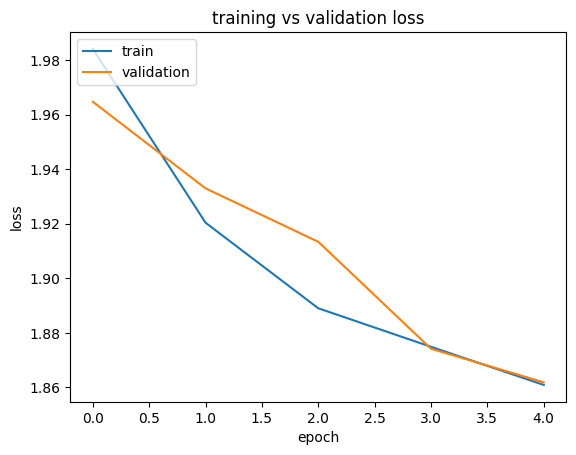

In [224]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('training vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [225]:
test_loss,accuracy = model.evaluate(X_test,y_test)

35/35 [==============================] - 4s 124ms/step - loss: 1.8356 - accuracy: 0.2934


In [226]:
test_loss,accuracy

(1.835606575012207, 0.29341864585876465)

In [244]:
EMBEDDINGS_DIMENSION

768

### CNN+LSTM

In [259]:
embedding = bert_embeddings
vocab_size = BERT_VOCAB_SIZE
embedding_dim = 768
learning_rate = 0.01
Embedding_layer = Embedding(vocab_size,embedding_dim,weights = [embedding],input_length = max_length_sequence, trainable=False)
model = Sequential()
model.add(Embedding_layer)
model.add(Conv1D(filters=32,kernel_size=5,activation="relu",padding="same",strides=1))
model.add(MaxPool1D(pool_size=2))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(32,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(9,"softmax"))
model.compile(loss="sparse_categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),metrics=["accuracy"])

2024-08-20 00:39:05,856 | WARNING | lstm.py:590 | __init__ | Layer lstm_13 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


In [260]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 186, 768)          14002176  
                                                                 
 conv1d_4 (Conv1D)           (None, 186, 32)           122912    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 93, 32)           0         
 1D)                                                             
                                                                 
 lstm_13 (LSTM)              (None, 100)               53200     
                                                                 
 dense_17 (Dense)            (None, 32)                3232      
                                                                 
 dropout_50 (Dropout)        (None, 32)                0         
                                                     

In [261]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
history = model.fit(X_train,y_train,epochs=5,batch_size=32,validation_data=(X_val, y_val),verbose=1,callbacks=[early_stopping],
                   workers=3)

Epoch 1/5
399/399 [==============================] - 348s 859ms/step - loss: 2.0472 - accuracy: 0.1557 - val_loss: 2.0318 - val_accuracy: 0.1622
Epoch 2/5
399/399 [==============================] - 360s 902ms/step - loss: 2.0356 - accuracy: 0.1656 - val_loss: 2.0299 - val_accuracy: 0.1584
Epoch 3/5
399/399 [==============================] - 385s 966ms/step - loss: 2.0310 - accuracy: 0.1624 - val_loss: 2.0303 - val_accuracy: 0.1492
Epoch 4/5
399/399 [==============================] - 385s 964ms/step - loss: 2.0305 - accuracy: 0.1614 - val_loss: 2.0299 - val_accuracy: 0.1654
Epoch 5/5
399/399 [==============================] - 387s 971ms/step - loss: 2.0307 - accuracy: 0.1598 - val_loss: 2.0299 - val_accuracy: 0.1654


In [262]:
train_pred = model.predict(X_train)
train_pred =  np.argmax(train_pred,axis=1)
train_model_performance = classification_metrics(y_train,train_pred,"macro")
train_model_performance

399/399 [==============================] - 47s 116ms/step


,precision,recall,f1,accuracy
0,0.018397,0.111111,0.031567,0.16557


In [263]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
test_model_performance = classification_metrics(y_test,y_pred,"macro")
test_model_performance

35/35 [==============================] - 4s 117ms/step


,precision,recall,f1,accuracy
0,0.018383,0.111111,0.031547,0.165448


In [264]:
test_loss,accuracy = model.evaluate(X_test,y_test)

35/35 [==============================] - 4s 118ms/step - loss: 2.0305 - accuracy: 0.1654


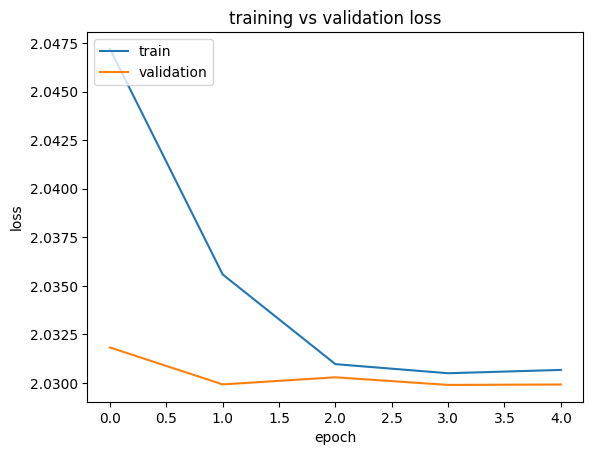

In [265]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('training vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### BERT

In [26]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=9)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
data_bin.Disorder.value_counts().index.tolist()

[8, 0, 2, 7, 1, 4, 6, 3, 5]

In [32]:
sample_df = pd.DataFrame()
for samples,count in dict(zip(data_bin.Disorder.value_counts().values.tolist(),data_bin.Disorder.value_counts().index.tolist())).items():
    if samples>1000:
        temp = data_bin[data_bin["Disorder"]==count]
        temp = temp.sample(1000)
    else:
        temp = data_bin[data_bin["Disorder"]==count]
    sample_df = pd.concat([temp,sample_df])

In [34]:
sample_df.Disorder.value_counts()

Disorder
6    1000
4    1000
1    1000
7    1000
2    1000
0    1000
8    1000
3     402
5     243
Name: count, dtype: int64

In [35]:
sample_df.head()

,Disorder,tweet
0,5,thank loudly cry face
1,5,neighborhood ginger coming say face blowing kiss
2,5,people followed people unfollowed automaticall...
3,5,people unfollowed automatically checked
4,5,right loudly cry face


In [36]:
data_bert = sample_df.copy()
data_bert["tweet"] = "[CLS] " +data_bert['tweet'] + "[SEP]"
X = data_bert[["tweet"]]
y = data_bert[["Disorder"]]

X_train,X_temp,y_train,y_temp = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)
X_val,X_test,y_val,y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42,stratify=y_temp)
train_text = X_train["tweet"].values.tolist()
train_label = y_train["Disorder"].values.tolist()

val_text = X_val["tweet"].values.tolist()
val_label = y_val["Disorder"].values.tolist()
test_text =  X_test["tweet"].values.tolist()
test_label = y_test["Disorder"].values.tolist()

In [37]:
print(X_train.shape,X_val.shape,X_test.shape)
print(np.unique(y_train,return_counts=True))
print(np.unique(y_val,return_counts=True))
print(np.unique(y_test,return_counts=True))

(5351, 1) (1835, 1) (459, 1)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([700, 700, 700, 281, 700, 170, 700, 700, 700], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([240, 240, 240,  97, 240,  58, 240, 240, 240], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([60, 60, 60, 24, 60, 15, 60, 60, 60], dtype=int64))


In [38]:
len(train_text),len(train_label)

(5351, 5351)

In [39]:
len(val_text),len(val_label)

(1835, 1835)

In [40]:
y_train.Disorder.value_counts()

Disorder
2    700
1    700
4    700
0    700
6    700
8    700
7    700
3    281
5    170
Name: count, dtype: int64

In [41]:
y_test.Disorder.value_counts()

Disorder
0    60
8    60
7    60
4    60
6    60
2    60
1    60
3    24
5    15
Name: count, dtype: int64

In [42]:
BERT_TOKENS_LENGTH = 256
max_length_sequence = min(max([len(doc) for doc in corpus]),BERT_TOKENS_LENGTH)
train_encoding = bert_tokenizer.batch_encode_plus(train_text,
                                              padding=True,
                                              truncation=True,
                                              max_length = max_length_sequence,
                                              return_tensors='tf')
val_encoding = bert_tokenizer.batch_encode_plus(val_text,
                                              padding=True, 
                                            truncation=True,
                                              max_length = max_length_sequence,
                                              return_tensors='tf')

In [43]:
train_encoding["input_ids"].shape,val_encoding["input_ids"].shape

(TensorShape([5351, 109]), TensorShape([1835, 186]))

In [51]:
# Compile the model with an appropriate optimizer, loss function, and metrics
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.compile(optimizer="adam", loss=loss, metrics=[metric])

In [52]:
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  6921      
                                                                 
Total params: 109,489,161
Trainable params: 109,489,161
Non-trainable params: 0
_________________________________________________________________


In [53]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

history = bert_model.fit(
    [train_encoding['input_ids'], train_encoding['token_type_ids'], train_encoding['attention_mask']],
    tf.convert_to_tensor(train_label, dtype=tf.int32),
    validation_data=(
      [val_encoding['input_ids'], val_encoding['token_type_ids'], val_encoding['attention_mask']], tf.convert_to_tensor(val_label, dtype=tf.int32)),
    batch_size=16,
    epochs=3,
    callbacks = [early_stopping]
)

Epoch 1/3
335/335 [==============================] - 198s 472ms/step - loss: 2.1781 - accuracy: 0.1383 - val_loss: 2.1911 - val_accuracy: 0.1308
Epoch 2/3
335/335 [==============================] - 152s 455ms/step - loss: 2.1554 - accuracy: 0.1217 - val_loss: 2.1447 - val_accuracy: 0.1308
Epoch 3/3
335/335 [==============================] - 152s 454ms/step - loss: 2.1421 - accuracy: 0.1291 - val_loss: 2.1350 - val_accuracy: 0.1308


In [54]:
test_encoding = bert_tokenizer.batch_encode_plus(test_text,
                                              padding=True, 
                                            truncation=True,
                                              max_length = max_length_sequence,
                                              return_tensors='tf')

In [55]:
test_loss, test_accuracy = bert_model.evaluate(
    [test_encoding['input_ids'], test_encoding['token_type_ids'], test_encoding['attention_mask']],
    tf.convert_to_tensor(test_label)
)

15/15 [==============================] - 10s 179ms/step - loss: 2.1356 - accuracy: 0.1307


In [56]:
test_loss, test_accuracy

(2.1356008052825928, 0.13071896135807037)

In [57]:
test_pred = bert_model.predict(
    [test_encoding['input_ids'], test_encoding['token_type_ids'], test_encoding['attention_mask']])

15/15 [==============================] - 9s 176ms/step


In [58]:
test_logits = test_pred.logits
test_pred_labels = tf.argmax(test_logits, axis=1)
test_pred_labels = test_pred_labels.numpy()

In [59]:
test_pred_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [60]:
# pred_labels = pred_labels.numpy()
 
# label = {
#     1: 'positive',
#     0: 'Negative'
# }

In [61]:
np.unique(test_pred_labels)

array([1], dtype=int64)

In [62]:
train_pred = bert_model.predict(
    [train_encoding['input_ids'], train_encoding['token_type_ids'], train_encoding['attention_mask']])

168/168 [==============================] - 45s 230ms/step


In [63]:
train_logits = train_pred.logits
train_labels = tf.argmax(train_logits, axis=1)
train_labels = train_labels.numpy()

In [64]:
np.unique(train_labels)

array([1], dtype=int64)

In [67]:
train_performance_table = classification_metrics(y_train.values,train_labels,"macro")
test_performance_table = classification_metrics(y_test.values,test_pred_labels,"macro")

In [68]:
train_performance_table

,precision,recall,f1,accuracy
0,0.014535,0.111111,0.025707,0.130817


In [69]:
test_performance_table

,precision,recall,f1,accuracy
0,0.014524,0.111111,0.02569,0.130719


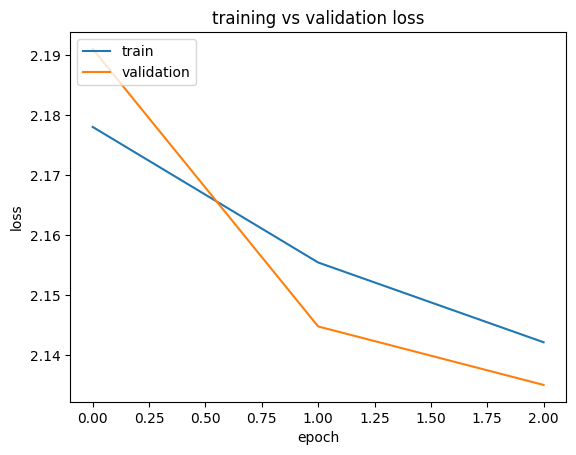

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('training vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()